In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
imgs, _ = next(iter(trainloader))
imgs.shape

torch.Size([64, 3, 32, 32])

torch.Size([64, 3, 32, 32])


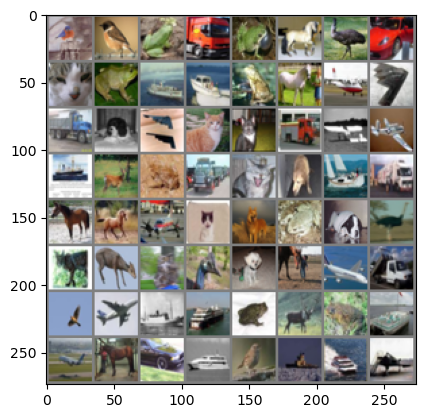

bird  bird  frog  truck frog  horse bird  car   cat   frog  ship  ship  frog  horse plane plane truck dog   plane cat   cat   truck plane plane ship  deer  frog  truck cat   dog   ship  truck horse horse plane cat   dog   frog  dog   bird  cat   deer  bird  bird  dog   horse plane truck bird  plane ship  ship  frog  deer  frog  ship  plane horse car   ship  bird  ship  ship  plane


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [60]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32, momentum=0.01)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.batchnorm2 = nn.BatchNorm2d(64, momentum=0.01)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.batchnorm3 = nn.BatchNorm1d(120, momentum=0.01)
        self.fc2 = nn.Linear(120, 84)
        self.batchnorm4 = nn.BatchNorm1d(84, momentum=0.01)
        self.fc3 = nn.Linear(84, 10)
        self.batchnorm5 = nn.BatchNorm1d(10, momentum=0.01)

    def forward(self, x):
        # (3, 32, 32)
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x))) # conv: (32 - 5 + 1) = 28 -> 6, 14, 14
        x = self.batchnorm1(x)
#         print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # conv: (14 - 5 + 1) = 10 -> 16, 5, 5 
        x = self.batchnorm2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.batchnorm3(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm4(x)
        x = self.fc3(x)
        x = self.batchnorm5(x)
        return x


model = Net()

In [61]:
with torch.no_grad():
    xbatch, ybatch = next(iter(trainloader))
    model(xbatch)

torch.Size([64, 3, 32, 32])


In [66]:
xi = torch.ones((64, 3, 32, 32))

In [68]:
64 * 3 * 32 * 32

196608

In [70]:
print(64 * 3 * 32)

6144


In [74]:
print(xi.sum())
print(xi.sum(dim=(0,1,2)))
print(xi.sum(dim=1).shape)
print(xi.sum(dim=(0, 2, 3)))

tensor(196608.)
tensor([6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144.,
        6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144.,
        6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144., 6144.,
        6144., 6144.])
torch.Size([64, 32, 32])
tensor([65536., 65536., 65536.])


In [50]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_acc, test_acc = [], []
train_loss, test_loss = [], []

In [51]:
def calculate_metrics(dataloader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct // total
    loss = running_loss / len(dataloader)
    model.train()
    return accuracy, loss

calculate_metrics(testloader)

(69, 0.8893291885685769)

In [57]:
import torch.optim as optim

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

train_acc, test_acc = [], []
train_loss, test_loss = [], []

In [58]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

        
    # evaluate metrics
    with torch.no_grad():
        tr_acc, tr_loss = calculate_metrics(trainloader)
        te_acc, te_loss = calculate_metrics(testloader)
        train_acc.append(tr_acc)
        test_acc.append(te_acc)
        train_loss.append(tr_loss)
        test_loss.append(te_loss)
        print(f'{epoch}. TRAIN acc: {tr_acc:.4f} loss: {tr_loss:.4f} TEST acc {te_acc:.4f} loss: {te_loss:.4f}')

print('Finished Training')

[1,   200] loss: 1.649
[1,   400] loss: 1.378
[1,   600] loss: 1.206
0. TRAIN acc: 64.0000 loss: 1.0077 TEST acc 62.0000 loss: 1.0779
[2,   200] loss: 1.028
[2,   400] loss: 1.016
[2,   600] loss: 0.976
1. TRAIN acc: 72.0000 loss: 0.8025 TEST acc 68.0000 loss: 0.9232
[3,   200] loss: 0.852
[3,   400] loss: 0.829
[3,   600] loss: 0.836
2. TRAIN acc: 75.0000 loss: 0.7167 TEST acc 68.0000 loss: 0.8931
[4,   200] loss: 0.721
[4,   400] loss: 0.728
[4,   600] loss: 0.737
3. TRAIN acc: 81.0000 loss: 0.5582 TEST acc 72.0000 loss: 0.8060
[5,   200] loss: 0.627
[5,   400] loss: 0.647
[5,   600] loss: 0.661
4. TRAIN acc: 84.0000 loss: 0.4692 TEST acc 73.0000 loss: 0.7836
[6,   200] loss: 0.558
[6,   400] loss: 0.569
[6,   600] loss: 0.592
5. TRAIN acc: 85.0000 loss: 0.4282 TEST acc 72.0000 loss: 0.8052
[7,   200] loss: 0.486
[7,   400] loss: 0.514
[7,   600] loss: 0.533
6. TRAIN acc: 88.0000 loss: 0.3512 TEST acc 73.0000 loss: 0.8063
[8,   200] loss: 0.422
[8,   400] loss: 0.457
[8,   600] loss:

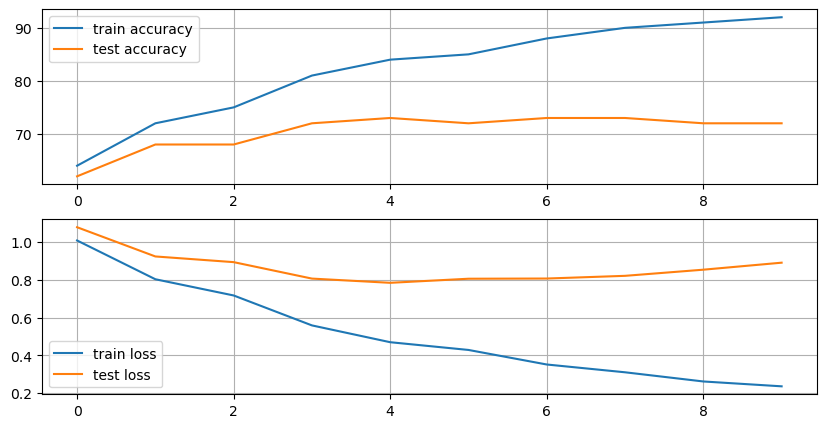

In [59]:
_, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(train_acc, label='train accuracy')
ax[0].plot(test_acc, label='test accuracy')

ax[1].plot(train_loss, label='train loss')
ax[1].plot(test_loss, label='test loss')

ax[0].legend()
ax[0].grid()
ax[1].legend()
ax[1].grid()

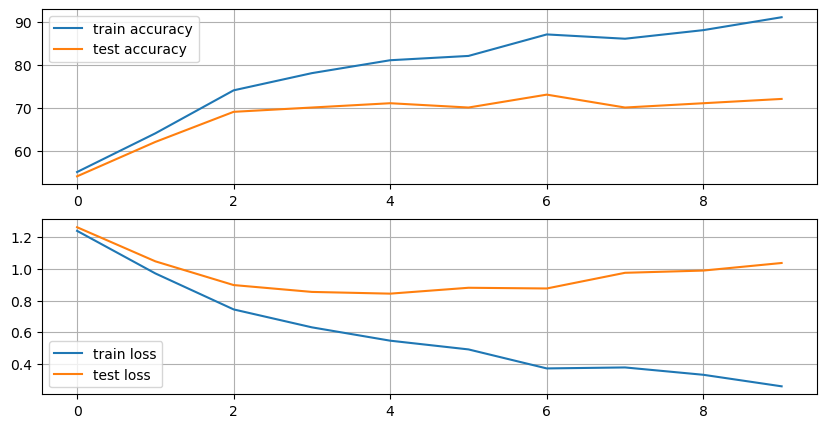

In [252]:
_, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(train_acc, label='train accuracy')
ax[0].plot(test_acc, label='test accuracy')

ax[1].plot(train_loss, label='train loss')
ax[1].plot(test_loss, label='test loss')

ax[0].legend()
ax[0].grid()
ax[1].legend()
ax[1].grid()

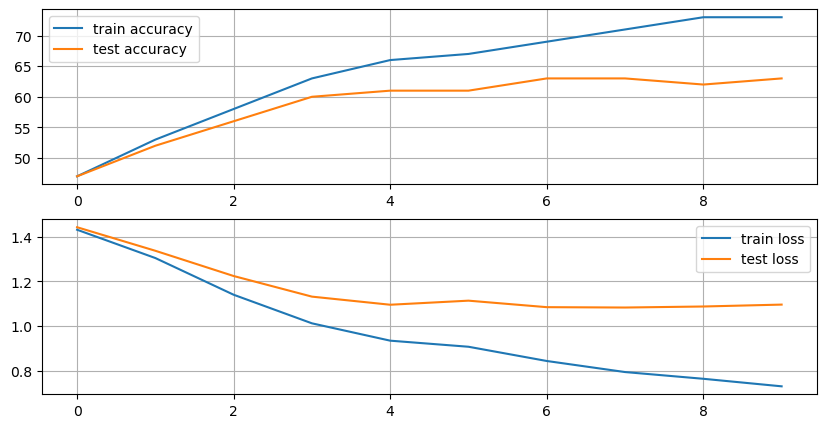

In [237]:
_, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(train_acc, label='train accuracy')
ax[0].plot(test_acc, label='test accuracy')

ax[1].plot(train_loss, label='train loss')
ax[1].plot(test_loss, label='test loss')

ax[0].legend()
ax[0].grid()
ax[1].legend()
ax[1].grid()

In [ ]:
print('train acc: {0:.4f}% loss: {1:.4f}'.format(*calculate_metrics(trainloader)))
print('test  acc: {0:.4f}% loss: {1:.4f}'.format(*calculate_metrics(testloader)))

In [179]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

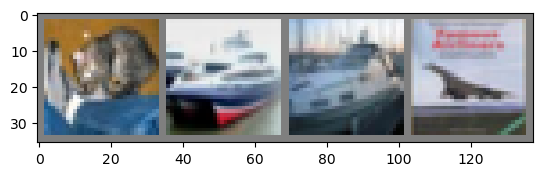

GroundTruth:  cat   ship  ship  plane


In [180]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [181]:
model = Net()
model.load_state_dict(torch.load(PATH))
outputs = model(images)

In [182]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane plane


In [187]:
len(trainloader)

12500

In [192]:
def calculate_metrics(dataloader):
    correct = 0
    total = 0
    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct // total
    loss = running_loss / len(dataloader)
    return accuracy, loss

calculate_metrics(testloader)

(54, 1.3000036110669375)

In [184]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 72.4 %
Accuracy for class: car   is 59.8 %
Accuracy for class: bird  is 48.0 %
Accuracy for class: cat   is 29.8 %
Accuracy for class: deer  is 31.3 %
Accuracy for class: dog   is 28.6 %
Accuracy for class: frog  is 64.6 %
Accuracy for class: horse is 61.9 %
Accuracy for class: ship  is 76.9 %
Accuracy for class: truck is 69.7 %
